### AUTHOR : Vaishnav Krishna P
vyshnavkrishnap2020@gmail.com

# 🩺 Skin Cancer Prediction Project  

This project aims to build a machine learning model to classify different types of skin cancer using images.  
The dataset is collected from **Kaggle - ISIC (International Skin Imaging Collaboration)**.  
- https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

### Dataset Information:
- Total Images: **2357**
- Categories (diseases included):
  - Actinic Keratosis  
  - Basal Cell Carcinoma  
  - Dermatofibroma  
  - Melanoma  
  - Nevus  
  - Pigmented Benign Keratosis  
  - Seborrheic Keratosis  
  - Squamous Cell Carcinoma  
  - Vascular Lesion  


### LOADING THE DATASET

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path (update the path according to your Drive location)
dataset_path = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration"

# Import libraries
import os

# Check training and testing directories
train_dir = os.path.join(dataset_path, "Train")
test_dir = os.path.join(dataset_path, "Test")

print("Training folders:", os.listdir(train_dir))
print("Testing folders:", os.listdir(test_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training folders: ['melanoma', 'pigmented benign keratosis', 'nevus', 'basal cell carcinoma', 'actinic keratosis', 'squamous cell carcinoma', 'vascular lesion', 'seborrheic keratosis', 'dermatofibroma']
Testing folders: ['melanoma', 'nevus', 'actinic keratosis', 'basal cell carcinoma', 'pigmented benign keratosis', 'squamous cell carcinoma', 'vascular lesion', 'seborrheic keratosis', 'dermatofibroma']


# 📊 Basic Information About the Dataset  
In this section, we will:
1. Load image data using `ImageDataGenerator`  
2. Understand class distribution (how many images per class)  
3. Apply basic preprocessing such as image rescaling and resizing  

In [5]:
# Import required libraries
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training Data (with validation split)
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

# Validation Data
val_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

# Test Data
test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # important for predictions
)

# Class Indices Mapping
print("\nClass indices mapping:")
print(train_data.class_indices)


Found 1971 images belonging to 9 classes.
Found 489 images belonging to 9 classes.
Found 118 images belonging to 9 classes.

Class indices mapping:
{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


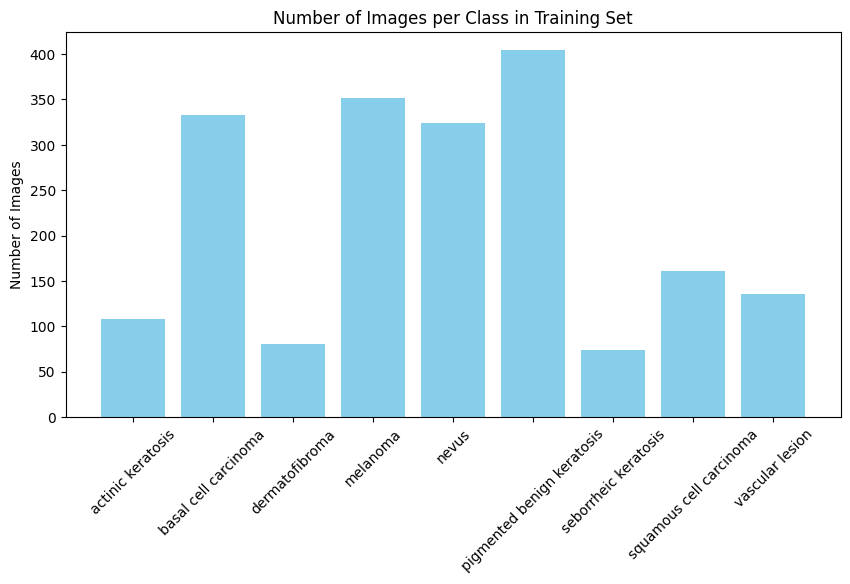

In [7]:
# Count images per class in training set
import numpy as np
import collections

# Get labels of all images in the training generator
labels = train_data.classes
label_counts = collections.Counter(labels)

# Map indices to class names
index_to_class = {v: k for k, v in train_data.class_indices.items()}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(index_to_class.values(), label_counts.values(), color='skyblue')
plt.title("Number of Images per Class in Training Set")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()


# 🔄 Data Transformation Techniques  

To improve model generalization and prevent overfitting, we apply **data augmentation techniques**.  
These transformations artificially increase dataset diversity by slightly altering the training images while keeping their labels the same.  

### Common Transformations:
- **Rotation** → Randomly rotates the image.  
- **Width & Height Shift** → Shifts image horizontally/vertically.  
- **Shear & Zoom** → Applies geometric distortions.  
- **Horizontal/Vertical Flip** → Flips the image to mimic real-world variations.  
- **Rescaling** → Normalizes pixel values (already applied).  


In [13]:
# Enhanced ImageDataGenerator with transformations
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Reload training data with augmentation
train_data_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

val_data_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

Found 1971 images belonging to 9 classes.
Found 489 images belonging to 9 classes.


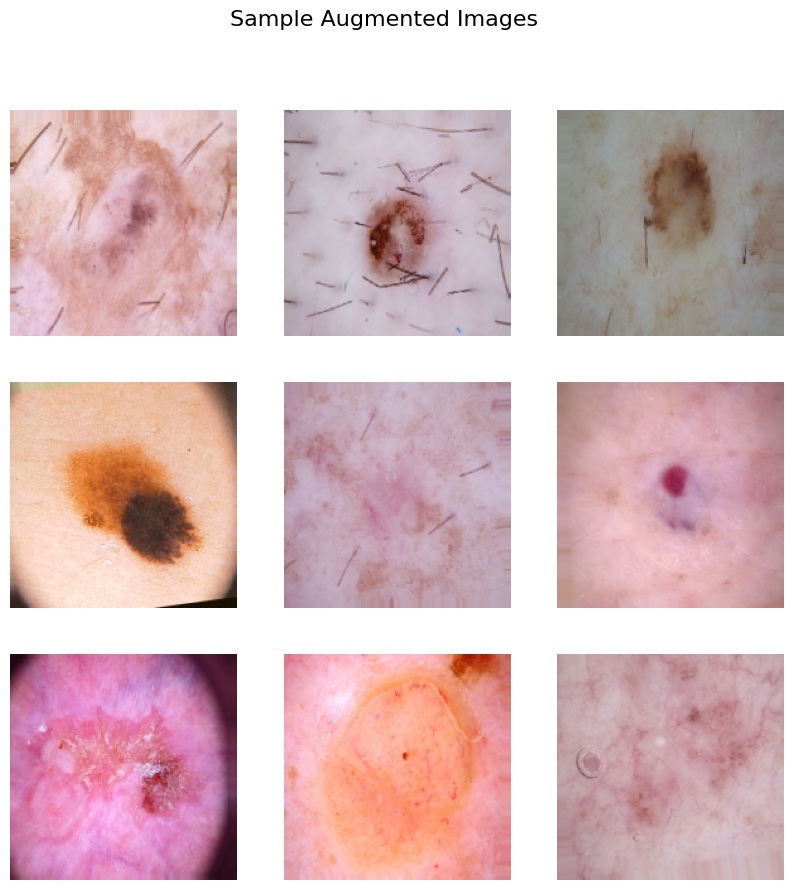

In [14]:

# Preview some augmented images
sample_images, sample_labels = next(train_data_aug)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle("Sample Augmented Images", fontsize=16)
plt.show()

# 🧠 Training a Basic CNN Model  

We will now build a **simple Convolutional Neural Network (CNN)** for image classification.  
The model is kept **lightweight** to reduce computational complexity while still learning useful features.  

### CNN Architecture:
1. **Conv2D + MaxPooling** layers → Extract features from images  
2. **Flatten** → Convert 2D feature maps into 1D vectors  
3. **Dense (Fully Connected) layers** → Classification  
4. **Softmax Output Layer** → Multi-class probabilities  

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),   # Prevent overfitting
    layers.Dense(len(train_data.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Keep epochs small for faster training (can be increased later)
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 561ms/step - accuracy: 0.1985 - loss: 2.2625 - val_accuracy: 0.2495 - val_loss: 1.9267
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 507ms/step - accuracy: 0.2995 - loss: 1.8919 - val_accuracy: 0.4131 - val_loss: 1.7063
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 445ms/step - accuracy: 0.4463 - loss: 1.6822 - val_accuracy: 0.4499 - val_loss: 1.6596
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 448ms/step - accuracy: 0.4496 - loss: 1.5641 - val_accuracy: 0.4417 - val_loss: 1.6277
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - accuracy: 0.4829 - loss: 1.5099 - val_accuracy: 0.4519 - val_loss: 1.6071
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 527ms/step - accuracy: 0.4911 - loss: 1.4525 - val_accuracy: 0.4519 - val_loss: 1.6196
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - accuracy: 0.5114 - loss: 1.4330 - val_accuracy: 0.4356 - val_loss: 1.6771
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 446ms/step - accuracy: 0.5324 - loss: 1.3315 - val_accu

- Accuracy is less - ~50 reasons,
1. Dataset is too small for the 9 classes
2. Basic CNN cannot capture the classification

# 🚀 Transfer Learning with MobileNetV2  

We will now use **MobileNetV2** as the feature extractor instead of training a CNN from scratch.  
This improves accuracy on **small datasets** and reduces computation, making it suitable for **Colab and Flask deployment**.  

### Steps:
1. Load pre-trained MobileNetV2 (without top layer).  
2. Freeze base model weights (so pretrained features are not destroyed).  
3. Add custom classification head for our **9 skin cancer classes**.  
4. Train only the top layers first.  


In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 without top layer (pretrained on ImageNet)
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze base model weights
base_model.trainable = False

# Build model
model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(train_data.class_indices), activation='softmax')  # Output layer for 9 classes
])

# Compile the model
model_mobilenet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_mobilenet.summary()

# Train only the top layers
history_mobilenet = model_mobilenet.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1
)


/tmp/ipython-input-4163887416.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 870ms/step - accuracy: 0.2749 - loss: 2.0679 - val_accuracy: 0.4070 - val_loss: 1.6901
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 443ms/step - accuracy: 0.4691 - loss: 1.5130 - val_accuracy: 0.4376 - val_loss: 1.5708
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 519ms/step - accuracy: 0.5196 - loss: 1.3507 - val_accuracy: 0.4785 - val_loss: 1.4795
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 439ms/step - accuracy: 0.5589 - loss: 1.2081 - val_accuracy: 0.4867 - val_loss: 1.4888
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 442ms/step - accuracy: 0.6183 - loss: 1.1082 - val_accuracy: 0.4703 - val_loss: 1.5384
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.6412 - loss: 1.0040 - val_accuracy: 0.4785 - val_loss: 1.5416
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 0.6741 - loss: 0.9338 - val_accuracy: 0.4826 - val_loss: 1.5362
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.6657 - loss: 0.9340 - val_accu

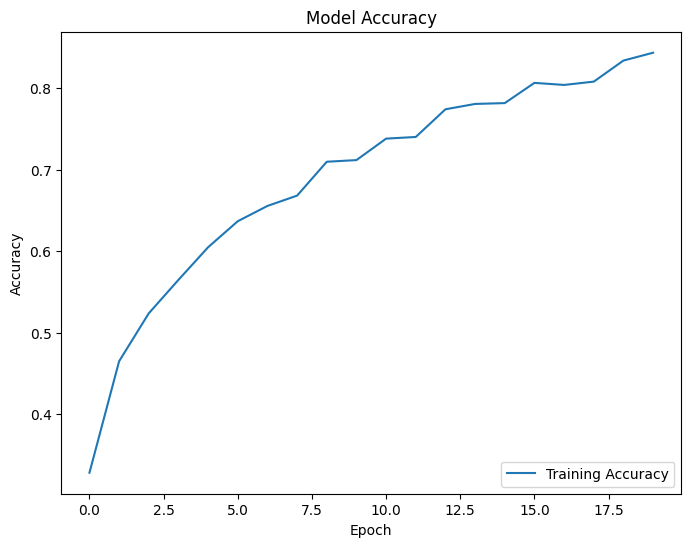

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
# plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

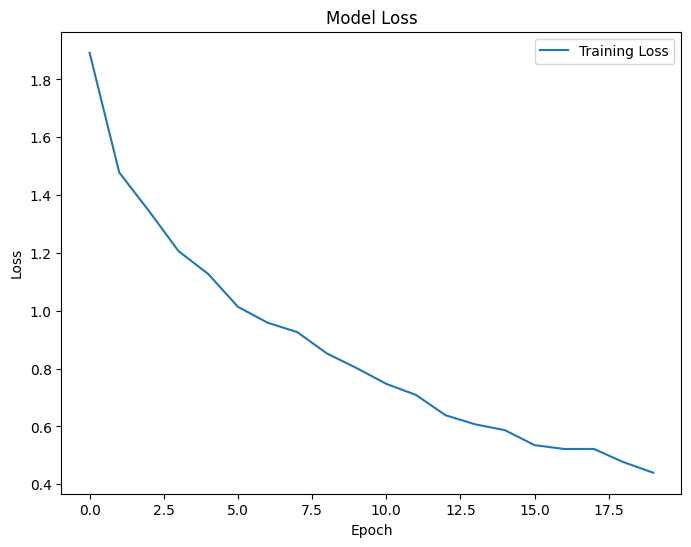

In [23]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
# plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### SAVING MODEL

In [27]:
# After training
model.save("mobilenet_model.h5")   # HDF5 format

### PREDICTION

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model("mobilenet_model.h5")

# Load a sample image (change the path to your test image)
img_path = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024475.jpg"
img_height, img_width = 180, 180  # same as training

# Preprocess the image
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img) / 255.0   # normalize
img_array = np.expand_dims(img_array, axis=0) # add batch dimension

# Make prediction
predictions = model.predict(img_array)

# Get class index with highest probability
predicted_class = np.argmax(predictions[0])

# Map back to class labels
class_indices = {v: k for k, v in train_data.class_indices.items()}
predicted_label = class_indices[predicted_class]

print(f"Predicted Class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
Predicted Class: vascular lesion
